# Juliaで信号処理の練習

# 環境構築
Windowsであれば，以下を参考にすればjupyterを使ってJuliaを実行できるようになるはず．  
[自分の PC にインストール · julia について](http://www.cas.cmc.osaka-u.ac.jp/~paoon/misc/julia/post/install/)
  
自分は，IJuliaのパッケージ追加でこけたので，次のようにビルドした．
```
using IJulia
//ここでIJuliaの導入が上手くいっていないと，ビルドコマンドを実行しろといわれる
Pkg.build("IJulia")
```
  
続けて，グラフを描画するためのパッケージを追加する．

```
Pkg.add("PyCall")
Pkg.add("PyPlot")
Pkg.add("Plots")
```
  
そこそこ時間がかかるので気長に待つ．
  
後は，伝達関数の設計とかボード線図の描画とかが手軽に行える，[ControlSystems.jl](https://github.com/JuliaControl/ControlSystems.jl)も入れておく．  
```
Pkg.add("ControlSystems")
```


# Hello, sine
オーディオプログラミングといったらまずはこれ

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

.Range{T} where T) in module Base at deprecated.jl:56 overwritten in module StatsBase at C:\Julia\PKG\v0.6\StatsBase\src\hist.jl:535.


In [2]:
#Pythonぽい書き方
function sinewave1(f, fs, sec)
    n = Int(fs * sec)
    x = linspace(0, sec, n)
    y = sin.(2*pi*f*x)
    
    return x, y
end

#ベタにループを回す
function sinewave2(f, fs, sec)
    ω = 2*pi*f
    n = Int(fs * sec)
    x = Array{Float64}(n)
    y = Array{Float64}(n)
    
    for i in 1:1:n
        x[i] = i/fs
        y[i] = sin(ω*x[i])
    end
    
    return x, y
end

sinewave2 (generic function with 1 method)

  0.211456 seconds (123.02 k allocations: 6.314 MiB)
  0.018074 seconds (3.89 k allocations: 230.289 KiB)



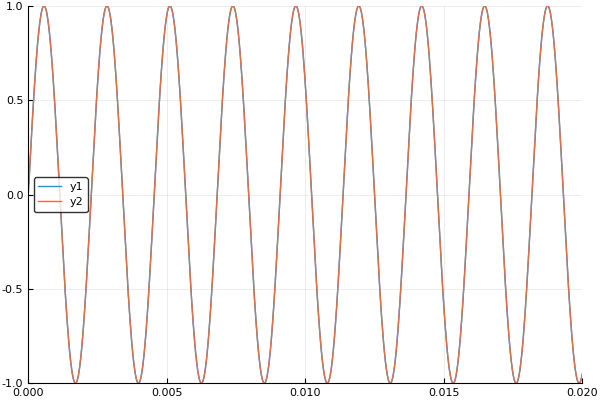

In [3]:
f = 440
fs = 48000
sec = 0.02

@time x1, y1 = sinewave1(f, fs, sec)
@time x2, y2 = sinewave2(f, fs, sec)

plot(x1, y1)
plot!(x2, y2)

はやい（確信）

# フィルタとか
RCローパスフィルタのボード線図を描画してみる

In [4]:
using ControlSystems

In [5]:
cutoff = [100, 250, 500, 1000, 2500]
sys = []

for fc in cutoff
    ωc = 2*pi*fc
    lpf = tf(ωc, [1, ωc])
    push!(sys, lpf)
end

sys

5-element Array{Any,1}:
 TransferFunction:
  628.3185307179587
---------------------
s + 628.3185307179587

Continuous-time transfer function model   
 TransferFunction:
  1570.7963267948965
----------------------
s + 1570.7963267948965

Continuous-time transfer function model
 TransferFunction:
  3141.592653589793
---------------------
s + 3141.592653589793

Continuous-time transfer function model   
 TransferFunction:
  6283.185307179586
---------------------
s + 6283.185307179586

Continuous-time transfer function model   
 TransferFunction:
  15707.963267948966
----------------------
s + 15707.963267948966

Continuous-time transfer function model


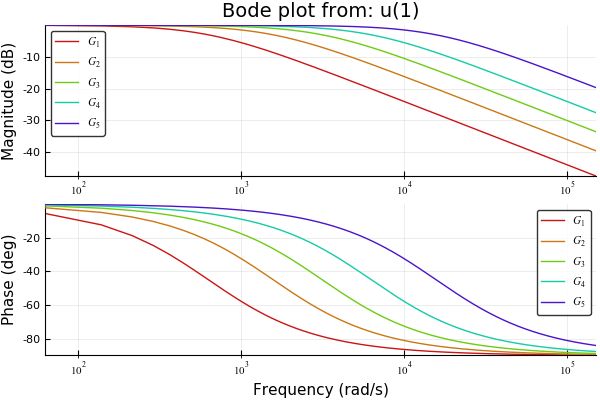

In [6]:
bodeplot([sys...], linspace(2*pi*10, 2*pi*24000, 2000))

横軸が角周波数なので分かりにくい  
Hzで表示したい


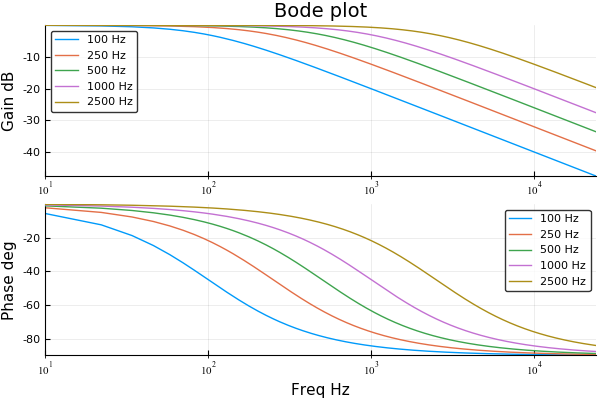

In [7]:
freq = linspace(10, 24000, 2000)
gain = []
phase = []
for tf in sys
    g, p = bode(tf, 2*pi*freq)
    push!(gain, 20*log10.(g[:]))
    push!(phase, p[:])
end

labels = [string(val)*" Hz" for val in cutoff]
labels = reshape(labels, 1, length(labels))

#labelは1*lengthのMatrix型 != Vector型
gp = plot(freq, gain, title="Bode plot", ylabel="Gain dB", xscale=:log10, label=labels)
pp = plot(freq, phase, xlabel="Freq Hz", ylabel="Phase deg", xscale=:log10, label=labels)
plot(gp, pp, layout=(2,1))

ちょっとめんどくさい…